[View in Colaboratory](https://colab.research.google.com/github/hypetrainai/hypetrain/blob/deepkaraoke/deepkaraoke/karaoke_mp3_preprocess.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pickle
import random
import scipy.io.wavfile
import scipy.signal
import shutil
import tempfile

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
#@title Parse data dir for *.mp3 and *_OffVocal.mp3

SAMPLING_RATE = 16000
data_dir = 'data/16k' #@param
data_dir = Path.resolve(Path(data_dir))
print('Loading from', data_dir)

off_vocal_files = sorted([str(f.as_posix()) for f in data_dir.glob('*_OffVocal.mp3')])
on_vocal_files = [f.replace('_OffVocal', '') for f in off_vocal_files]
print('Loaded %d files' % len(off_vocal_files))

Loading from data/16k


AttributeError: 'str' object has no attribute 'glob'

In [12]:
def FindInSeq(seq, pattern):
  """Finds 'pattern' in 'seq'.
  
  The pattern will be perfectly aligned to seq, but there may be a signal that's
  been added or removed. This tries to find that alignment.
  
  Args:
    seq: the sequence containing the pattern to find, with an additional signal
      either added or removed.
    pattern: the pattern to find. Must be no longer than seq. Must be reasonably
      close to the length of seq.
      
  Raises:
    ValueError if the pattern is longer than seq or is much shorter than seq.
  
  Returns:
    the index of 'pattern' in 'seq'.
  """
  if len(pattern) > len(seq):
    raise ValueError('pattern must be no longer than seq.')
  if len(seq) - len(pattern) > 3 * SAMPLING_RATE:
    raise ValueError('pattern must not be too much shorter than seq.')
  
  seq = seq / np.std(seq)
  pattern = pattern / np.std(pattern)
  corr = scipy.signal.correlate(seq, pattern, 'valid', 'fft')
  if np.argmax(corr) != 0:
    plt.plot(range(len(corr)), corr)
    plt.show()
  return np.argmax(corr)

/home/joe/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


ChiyoriUtau.mp3: shifting by 0.


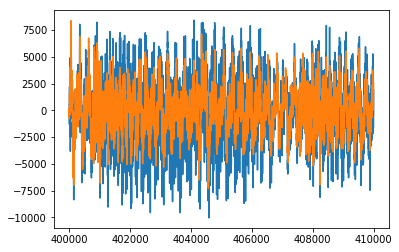

Dearest.mp3: shifting by 0.


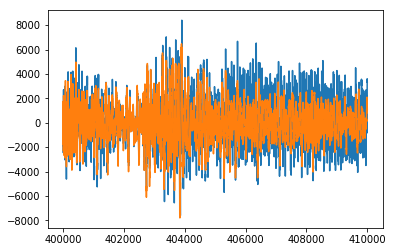

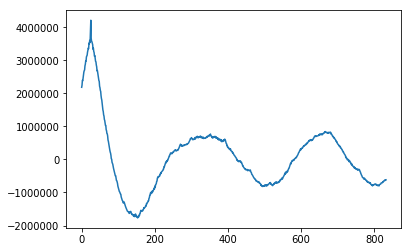

Encounter.mp3: shifting by 25.


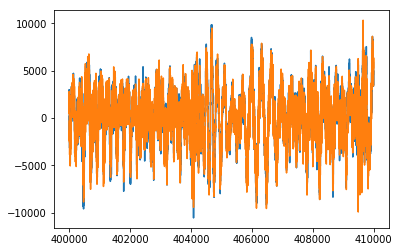

KazegaSaeruyoriHayaku.mp3: shifting by 0.


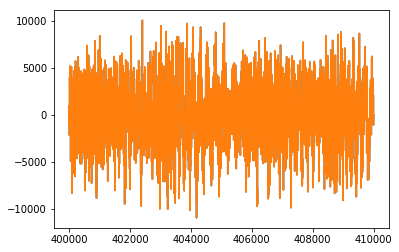

KyoumeiShinaiAinoKatachi.mp3: shifting by 0.


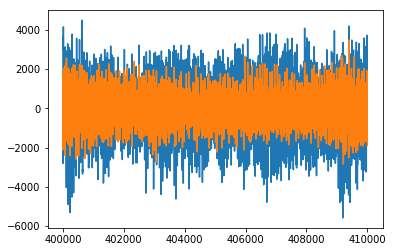

MahougaUmaretaHi.mp3: shifting by 0.


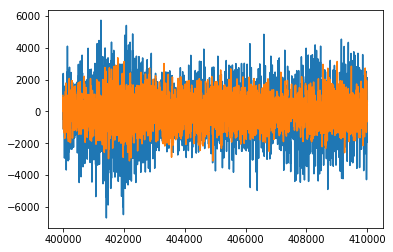

MujakitoIuNanoSeigi.mp3: shifting by 0.


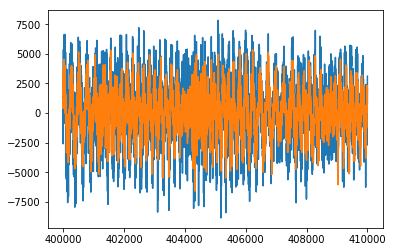

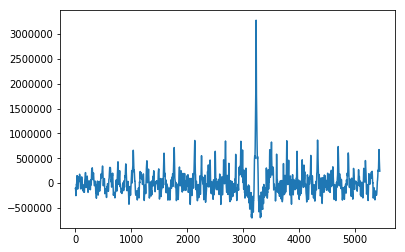

Muketsu.mp3: shifting by 3230.


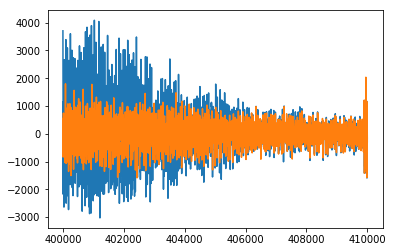

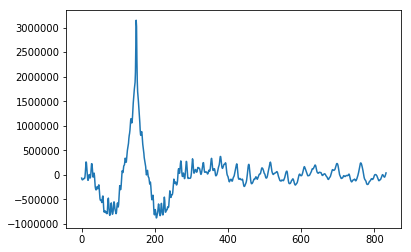

Reincarnation.mp3: shifting by 149.


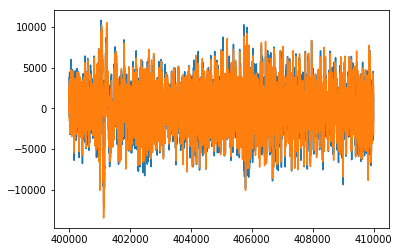

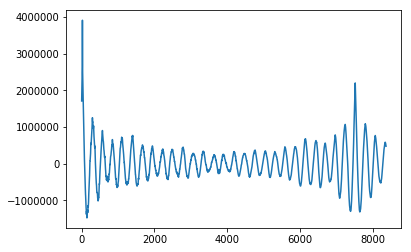

RunThroughtheNight.mp3: shifting by 21.


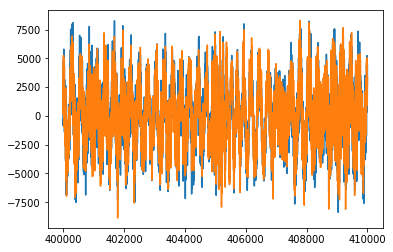

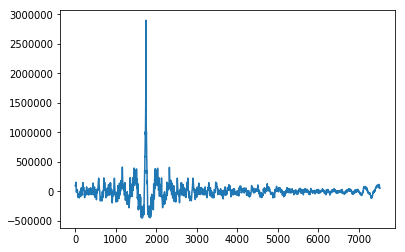

Sakurakaze.mp3: shifting by 1740.


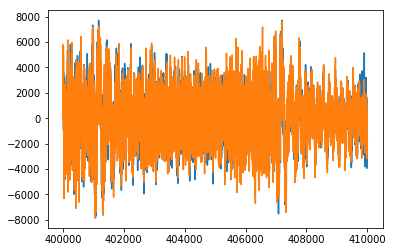

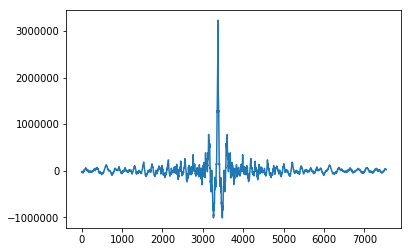

Stella-rium.mp3: shifting by 3373.


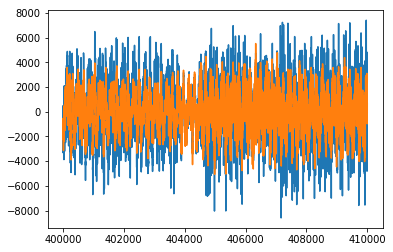

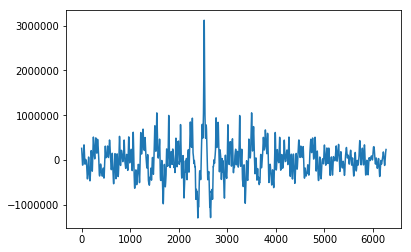

TanjoubinoKodomotachi.mp3: shifting by 2525.


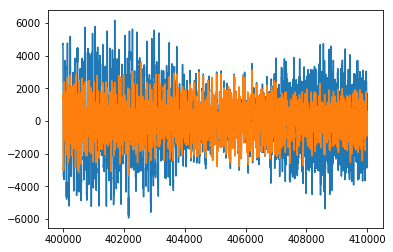

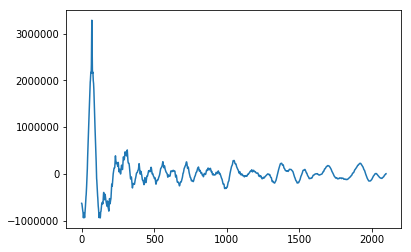

WalkThisWay.mp3: shifting by 70.


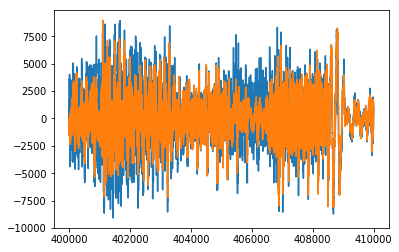

Train: dict_keys(['Stella-rium.mp3', 'MujakitoIuNanoSeigi.mp3', 'MahougaUmaretaHi.mp3', 'Sakurakaze.mp3', 'Muketsu.mp3', 'WalkThisWay.mp3', 'ChiyoriUtau.mp3', 'Reincarnation.mp3', 'RunThroughtheNight.mp3', 'TanjoubinoKodomotachi.mp3'])
data/16k
Test: dict_keys(['Encounter.mp3', 'KazegaSaeruyoriHayaku.mp3', 'Dearest.mp3', 'KyoumeiShinaiAinoKatachi.mp3'])


In [13]:
all_data = []
for on_vocal, off_vocal in zip(on_vocal_files, off_vocal_files):
  tmpdir = tempfile.mkdtemp()
  filename = Path(os.path.join(tmpdir, 'on_vocal.wav')).as_posix()
  !sox "$on_vocal" "$filename"
  data_on = scipy.io.wavfile.read(filename)
  
  filename = Path(os.path.join(tmpdir, 'off_vocal.wav')).as_posix()
  !sox "$off_vocal" "$filename"
  data_off = scipy.io.wavfile.read(filename)
  shutil.rmtree(tmpdir)
  
  assert data_on[0] == data_off[0] == SAMPLING_RATE
  a, b = data_on[1][:, 0], data_off[1][:, 0]
  swapped = False
  if len(b) > len(a):
    a, b = b, a
    swapped = True
  
  shift = FindInSeq(a, b)
  print('%s: shifting by %d.' % (os.path.basename(on_vocal), shift))
  
  a = a[shift:shift+len(b)]
  if swapped:
    a, b = b, a
  data_on, data_off = a, b
  all_data.append((os.path.basename(on_vocal), data_on, data_off))
  
  plot_len = 10000
  step = 1
  start = 400000
  plt.plot(range(start, start + plot_len, step), data_on[start:start+plot_len:step], label="data_on")
  plt.plot(range(start, start + plot_len, step), data_off[start:start+plot_len:step], label="data_off")
  plt.show()
  
idx = np.array(range(len(all_data)))
np.random.seed(12345678)
np.random.shuffle(idx)
num_train = int(0.75 * len(all_data))

train_data = {}
for i in range(num_train):
  filename, data_on, data_off = all_data[idx[i]]
  train_data[filename] = data_on, data_off
print('Train:', train_data.keys())
print(data_dir)
with open(os.path.join(str(data_dir), 'train.pkl.gz'), 'wb') as f:
    pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
test_data = {}
for i in range(num_train, len(all_data)):
  filename, data_on, data_off = all_data[idx[i]]
  test_data[filename] = data_on, data_off
print('Test:', test_data.keys())
with open(os.path.join(data_dir, 'test.pkl.gz'), 'wb') as f:
    pickle.dump(test_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
data_dir = '/home/joe/projects/hypetrain/deepkaraoke/data/16k'
print(os.path.join(data_dir, 'train.pkl.gz'))
with open(os.path.join(data_dir, 'train.pkl.gz'), 'wb') as f:
    print(f)

/home/joe/projects/hypetrain/deepkaraoke/data/16k/train.pkl.gz
<_io.BufferedWriter name='/home/joe/projects/hypetrain/deepkaraoke/data/16k/train.pkl.gz'>
